In [70]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [71]:
conn = sqlite3.connect("../bmarket.db")
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(tables)

[('bank_marketing',)]


In [72]:
df = pd.read_sql_query("SELECT * FROM bank_marketing", conn)
df.head(5)

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,32885,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,3170,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,14021,27 years,housemaid,married,high.school,no,None,no,Cell,2,999,no


## Initial Data Understanding

In [73]:
df.info()

# *** insight from .info() ***
# There is 2 columns (Housing Loan & Personal Loan) with that contain null values
# For data type, the "Age" column should not be "object" type, by logic it should be converted to integer
# for further processing use (ML training, analysis)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Client ID              41188 non-null  int64 
 1   Age                    41188 non-null  object
 2   Occupation             41188 non-null  object
 3   Marital Status         41188 non-null  object
 4   Education Level        41188 non-null  object
 5   Credit Default         41188 non-null  object
 6   Housing Loan           16399 non-null  object
 7   Personal Loan          37042 non-null  object
 8   Contact Method         41188 non-null  object
 9   Campaign Calls         41188 non-null  int64 
 10  Previous Contact Days  41188 non-null  int64 
 11  Subscription Status    41188 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.8+ MB


In [96]:
# Check for duplicates
df.duplicated().sum()

np.int64(0)

In [ ]:
# Check how many cell/data entries are null values
df.isnull().sum()

Client ID                    0
Age                          0
Occupation                   0
Marital Status               0
Education Level              0
Credit Default               0
Housing Loan             22309
Personal Loan             3738
Contact Method               0
Campaign Calls               0
Previous Contact Days        0
Subscription Status          0
dtype: int64

Subscription Status
no     0.887346
yes    0.112654
Name: count, dtype: float64

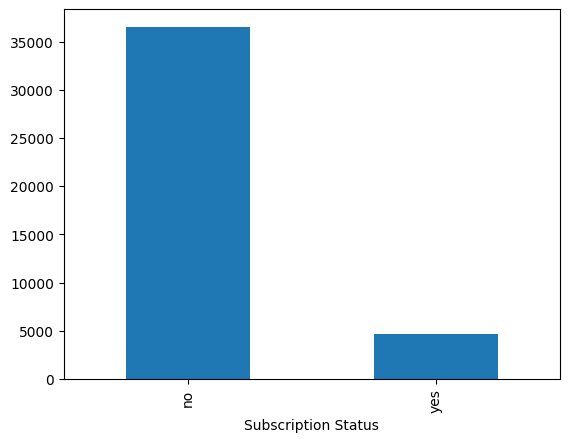

In [74]:
df['Subscription Status'].value_counts().plot(kind='bar')
df['Subscription Status'].value_counts()/df.shape[0]

# purpose is to check for distribution of the target column 

# *** Insights ***
# Dataset is highly imbalanced. ~88.7% not subscribed, only ~ 11.3% subscribed 

# The majority class dominates, which can affect model training & performance hence
# might require class balancing techniques

# Might consider metrics like F1 because it focuses on the minority class (Subscription = Yes) as well
# and provide a more realistic measure of how well the model captures true subscribers.

# Using FI score tells how well the model identifies actual subscribers (Subscription = Yes)

# Accuracy might be misleading (For example, if model predicts "No" for all the data entries --> 88.7% accuracy)


## Data Cleaning

### 1a) "Age" Column fix

In [75]:
# *** "Age" column fix *** 

# Observation 1 --> Data type is "object" 
# Fix done --> Removing the word "years" in all data entries in the "Age" column --> converting to integers

df["Age"] = df["Age"].str.replace(" years", "", regex=False).astype(int)
df.head(5)

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,32885,57,technician,married,high.school,no,no,yes,Cell,1,999,no
1,3170,55,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,32207,33,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,9404,36,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,14021,27,housemaid,married,high.school,no,None,no,Cell,2,999,no


In [76]:
# Check whether "Age" column is changed to integers
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Client ID              41188 non-null  int64 
 1   Age                    41188 non-null  int64 
 2   Occupation             41188 non-null  object
 3   Marital Status         41188 non-null  object
 4   Education Level        41188 non-null  object
 5   Credit Default         41188 non-null  object
 6   Housing Loan           16399 non-null  object
 7   Personal Loan          37042 non-null  object
 8   Contact Method         41188 non-null  object
 9   Campaign Calls         41188 non-null  int64 
 10  Previous Contact Days  41188 non-null  int64 
 11  Subscription Status    41188 non-null  object
dtypes: int64(4), object(8)
memory usage: 3.8+ MB


In [77]:
print("Age range:", df["Age"].min(), "to", df["Age"].max())

Age range: 17 to 150


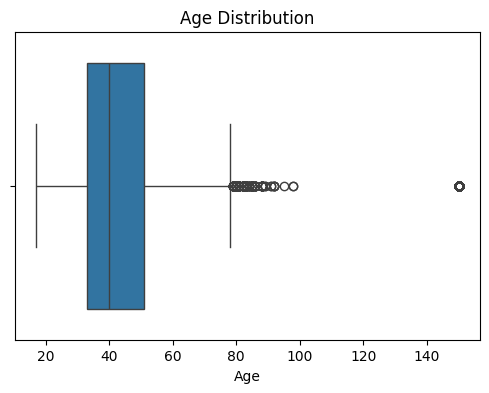

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["Age"])

plt.title("Age Distribution")
plt.xlabel("Age")

plt.show()

# Observation 2 --> There are age that are unreasonable (For exmaple: 150 year old), hence it should be dropped
# For reasonable & valid age range according to the average human lifespan, we assumed it be be between the range of 0 to 100 years old



In [89]:
print("No of entries with Age out of range:", ((df["Age"] > 100) | (df["Age"] < 0)).sum())


No of entries with Age out of range: 4197


In [90]:
df.drop(df[df["Age"] > 100].index, inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 36991 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Client ID              36991 non-null  int64 
 1   Age                    36991 non-null  int64 
 2   Occupation             36991 non-null  object
 3   Marital Status         36991 non-null  object
 4   Education Level        36991 non-null  object
 5   Credit Default         36991 non-null  object
 6   Housing Loan           14682 non-null  object
 7   Personal Loan          33253 non-null  object
 8   Contact Method         36991 non-null  object
 9   Campaign Calls         36991 non-null  int64 
 10  Previous Contact Days  36991 non-null  int64 
 11  Subscription Status    36991 non-null  object
dtypes: int64(4), object(8)
memory usage: 3.7+ MB


### 1b) Cleaning columns with "Unknown"

In [ ]:
# df[df.eq("unknown").any(axis=1)]
df.eq("unknown").sum()


Client ID                   0
Age                         0
Occupation                299
Marital Status             71
Education Level          1575
Credit Default           7716
Housing Loan              350
Personal Loan             785
Contact Method              0
Campaign Calls              0
Previous Contact Days       0
Subscription Status         0
dtype: int64

In [ ]:
unknown_counts = df.eq("unknown").sum()
unknown_counts = unknown_counts[unknown_counts > 0]
unknown_counts


Occupation          299
Marital Status       71
Education Level    1575
Credit Default     7716
Housing Loan        350
Personal Loan       785
dtype: int64

### 1c) Feature Engineering ("Education Level (No of Years)")

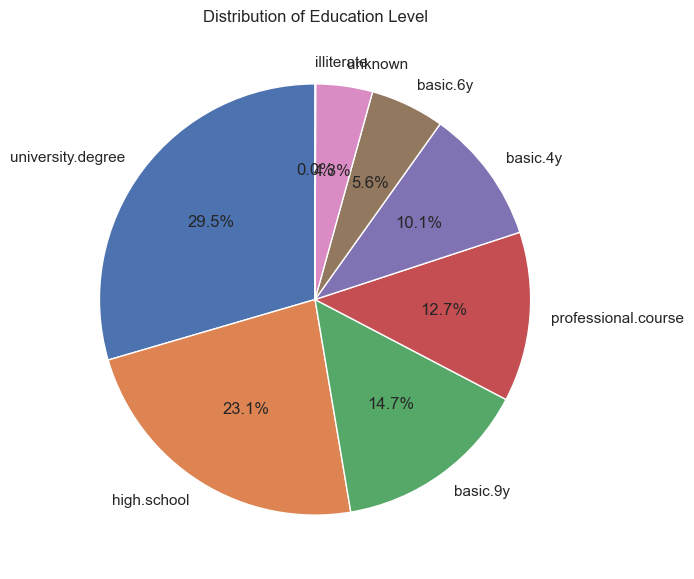

In [105]:
edu_pct = df["Education Level"].value_counts(normalize=True) *100

# use seaborn style
sns.set_theme(style="whitegrid")

plt.figure(figsize=(7,7))
plt.pie(
    edu_pct.values,
    labels=edu_pct.index,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Distribution of Education Level")
plt.show()


In [110]:
year_education_map = {
    'illiterate': 0,
    'basic.4y': 4,
    'basic.6y': 6,
    'basic.9y': 9,
    'high.school': 10,
    'professional.course': 13,
    'university.degree': 17,
    'unknown': np.nan   # or assign a value like df['Year of Education'].median()
}

In [111]:
df['Year of Education'] = df['Education Level'].map(year_education_map)
df

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Year of Education
0,32885,57,technician,married,high.school,no,no,yes,Cell,1,999,no,10.0
1,3170,55,unknown,married,unknown,unknown,yes,no,telephone,2,999,no,NaN
2,32207,33,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no,9.0
3,9404,36,admin.,married,high.school,no,no,no,Telephone,4,999,no,10.0
4,14021,27,housemaid,married,high.school,no,None,no,Cell,2,999,no,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,6266,58,retired,married,professional.course,unknown,no,no,Telephone,2,999,no,13.0
41184,11285,37,management,married,university.degree,no,no,no,telephone,1,999,no,17.0
41185,38159,35,admin.,married,high.school,no,None,no,cellular,1,4,yes,10.0
41186,861,40,management,married,university.degree,no,None,no,telephone,2,999,no,17.0


In [112]:
education_map = {
    'illiterate': 'illiterate',
    
    # group all basic-level educations
    'basic.4y': 'basic',
    'basic.6y': 'basic',
    'basic.9y': 'basic',
    
    'high.school': 'high.school',
    'professional.course': 'professional.course',
    'university.degree': 'university.degree',
    
    'unknown': np.nan   # treat unknown as missing
}

In [113]:
df['Education Level'] = df['Education Level'].map(education_map)
df

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Year of Education
0,32885,57,technician,married,high.school,no,no,yes,Cell,1,999,no,10.0
1,3170,55,unknown,married,NaN,unknown,yes,no,telephone,2,999,no,NaN
2,32207,33,blue-collar,married,basic,no,no,no,cellular,1,999,no,9.0
3,9404,36,admin.,married,high.school,no,no,no,Telephone,4,999,no,10.0
4,14021,27,housemaid,married,high.school,no,None,no,Cell,2,999,no,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,6266,58,retired,married,professional.course,unknown,no,no,Telephone,2,999,no,13.0
41184,11285,37,management,married,university.degree,no,no,no,telephone,1,999,no,17.0
41185,38159,35,admin.,married,high.school,no,None,no,cellular,1,4,yes,10.0
41186,861,40,management,married,university.degree,no,None,no,telephone,2,999,no,17.0
